In [7]:
# 1. Загрузить набор данных из репозитория. Свой выбор данных  согласовать с преподавателем.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


df = pd.read_csv("./data/global_cancer_patients_2015_2024.csv")

print(df.info())

df = df.drop_duplicates()

df = df.drop("Patient_ID", axis=1)
df = df.drop("Treatment_Cost_USD", axis=1)
df = df.drop("Year", axis=1)

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  50000 non-null  float64
dtypes:

,Age,Gender,Country_Region,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Survival_Years,Target_Severity_Score
0,71,Male,UK,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,5.9,4.92
1,34,Male,China,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,4.7,4.65
2,80,Male,Pakistan,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,7.1,5.84
3,40,Male,UK,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,1.6,3.12
4,43,Female,Brazil,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,2.9,3.62


In [8]:
# 5. Отобрать и определить признаки, которые будут использоваться для построения моделей.

important_feat = [
    "Age",
    "Gender",
    "Country_Region",
    "Genetic_Risk",
    "Air_Pollution",
    "Alcohol_Use",
    "Smoking",
    "Obesity_Level",
    "Cancer_Type"
    "Cancer_Stage",
]

numeric_columns = [
    "Age",
    "Genetic_Risk",
    "Air_Pollution",
    "Alcohol_Use",
    "Smoking",
    "Obesity_Level",
    "Survival_Years",
    "Target_Severity_Score",
]


categorical_columns = [
    "Gender",
    "Country_Region",
    "Cancer_Type",
    "Cancer_Stage",
]

target = "Cancer_type"
df.head()

,Age,Gender,Country_Region,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Survival_Years,Target_Severity_Score
0,71,Male,UK,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,5.9,4.92
1,34,Male,China,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,4.7,4.65
2,80,Male,Pakistan,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,7.1,5.84
3,40,Male,UK,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,1.6,3.12
4,43,Female,Brazil,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,2.9,3.62


In [11]:
# Кодирование категориальных признаков
df[categorical_columns] = df[categorical_columns].apply(LabelEncoder().fit_transform) # type: ignore

# Целевой признак
target = df["Cancer_Type"]
features = df.drop(columns=["Cancer_Type"])

# StandardScaler для f_classif
scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(features)

# MinMaxScaler для chi2
scaler_mm = MinMaxScaler()
X_scaled_mm = scaler_mm.fit_transform(features)

# Разбиение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_std, target, test_size=0.2, random_state=42
)

X_train_mm, X_test_mm, _, _ = train_test_split(
    X_scaled_mm, target, test_size=0.2, random_state=42
)

In [12]:
model_all = RandomForestClassifier(random_state=42)
model_all.fit(X_train, y_train)
y_pred_all = model_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print(f"Accuracy на всех признаках: {accuracy_all:.4f}")

Accuracy на всех признаках: 0.1177


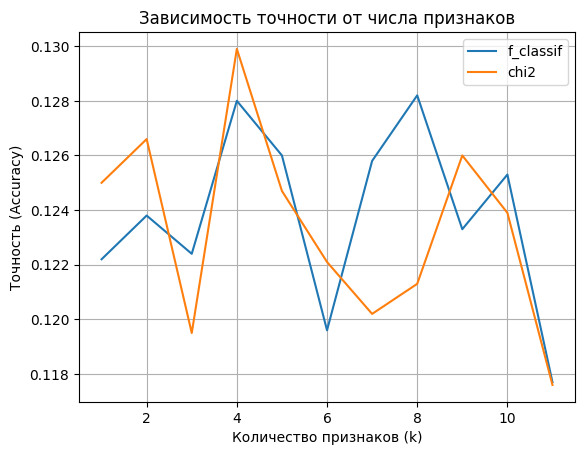

In [14]:
def test_select_kbest(score_func, score_name, X_train, X_test, y_train, y_test):
    k_values = range(1, X_train.shape[1] + 1)
    accuracies = []

    for k in k_values:
        selector = SelectKBest(score_func=score_func, k=k)
        X_train_k = selector.fit_transform(X_train, y_train)
        X_test_k = selector.transform(X_test)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_k, y_train)
        y_pred = model.predict(X_test_k)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    plt.plot(k_values, accuracies, label=score_name)
    return accuracies


# f_classif (на стандартизированных данных)
acc_f_classif = test_select_kbest(
    f_classif, "f_classif", X_train, X_test, y_train, y_test
)

# chi2 (на неотрицательных данных)
acc_chi2 = test_select_kbest(chi2, "chi2", X_train_mm, X_test_mm, y_train, y_test)

# График
plt.xlabel("Количество признаков (k)")
plt.ylabel("Точность (Accuracy)")
plt.title("Зависимость точности от числа признаков")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Модель на всех признаках (стандартизированных)
model_all = RandomForestClassifier(random_state=42)
model_all.fit(X_train, y_train)
y_pred_all = model_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)

# Вывод результатов
print(f"Точность модели на всех признаках: {accuracy_all:.4f}")
print(f"Максимальная точность при f_classif: {max(acc_f_classif):.4f}")
print(f"Максимальная точность при chi2: {max(acc_chi2):.4f}")

Точность модели на всех признаках: 0.1177
Максимальная точность при f_classif: 0.1282
Максимальная точность при chi2: 0.1299
